Adapted by Carlos Toxtli https://www.carlostoxtli.com/#colab-gan-2

Source: https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/infoGAN.ipynb

In [ ]:
!pip install tensorboardX
!mkdir samples

     |████████████████████████████████| 225kB 35.1MB/s 


# Implementation of infoGANs
Reference: https://arxiv.org/pdf/1606.03657.pdf

In [ ]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
import numpy as np
import datetime
import os, sys

In [ ]:
from tensorboardX import SummaryWriter

In [ ]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [ ]:
MODEL_NAME = 'infoGAN'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [ ]:
def sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=None, supervised=False):
    z = torch.randn(batch_size, n_noise).to(DEVICE)
    if supervised:
        c_discrete = to_onehot(label).to(DEVICE) # (B,10)
    else:
        c_discrete = to_onehot(torch.LongTensor(batch_size, 1).random_(0, n_c_discrete)).to(DEVICE) # (B,10)
    c_continuous = torch.zeros(batch_size, n_c_continuous).uniform_(-1, 1).to(DEVICE) # (B,2)
    c = torch.cat((c_discrete.float(), c_continuous), 1)
    return z, c

In [ ]:
def get_sample_image():
    """
        save sample 100 images
    """
    images = []
    # continuous code
    for cc_type in range(2):
        for num in range(10):
            fix_z = torch.randn(1, n_noise)
            z = fix_z.to(DEVICE)
            cc = -1
            for i in range(10):
                cc += 0.2
                c_discrete = to_onehot(num).to(DEVICE) # (B,10)
                c_continuous = torch.zeros(1, n_c_continuous).to(DEVICE)
                c_continuous.data[:,cc_type].add_(cc)
                c = torch.cat((c_discrete.float(), c_continuous), 1)
                y_hat = G(z, c)
                line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
            all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
        img = all_img.cpu().data.numpy()
        images.append(img)
    # discrete code
    for num in range(10):
        c_discrete = to_onehot(num).to(DEVICE) # (B,10)
        for i in range(10):
            z = torch.randn(1, n_noise).to(DEVICE)
            c_continuous = torch.zeros(1, n_c_continuous).to(DEVICE)
            c = torch.cat((c_discrete.float(), c_continuous), 1)
            y_hat = G(z, c)
            line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
        all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
    img = all_img.cpu().data.numpy()
    images.append(img)
    return images[0], images[1], images[2]

In [ ]:
def log_gaussian(c, mu, var):
    """
        criterion for Q(condition classifier)
    """
    return -((c - mu)**2)/(2*var+1e-8) - 0.5*torch.log(2*np.pi*var+1e-8)

In [ ]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(# 28 -> 14
            nn.Conv2d(in_channel, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
        )
        self.layer2 = nn.Sequential(# 14 -> 7
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        self.layer3 = nn.Sequential(#
            nn.Linear(128*7*7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = self.layer1(x)
        y_ = self.layer2(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.layer3(y_)
        d = self.fc(y_) # Real / Fake        
        return d, y_ # return with top layer features for Q

In [ ]:
class Qrator(nn.Module):
    """
        Regularization Network for increasing Mutual Information
    """
    def __init__(self):
        super(Qrator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 14),
        )
        
    def forward(self, x):
        # Seperate code
        c = self.fc(x)
        c_discrete = torch.softmax(c[:, :10], dim=-1) # Digit Label {0~9}
        c_mu = c[:, 10:12] # mu & var of Rotation & Thickness
        c_var = c[:, 12:14].exp() # mu & var of Rotation & Thickness
        return c_discrete, c_mu, c_var

In [ ]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=62, code_size=12, num_classes=784):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size+code_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(# input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(# input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, z, c):
        z = z.view(z.size(0), -1)
        c = c.view(c.size(0), -1)
        noise = torch.cat((z, c), 1)
#         print(noise.size())
        x_ = self.layer1(noise)
        x_ = self.layer2(x_)
        x_ = x_.view(x_.size(0), 128, 7, 7)
        x_ = self.layer3(x_)
        x_ = self.layer4(x_)
        return x_

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
Q = Qrator().to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [ ]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

0it [00:00, ?it/s]

100%|█████████▉| 9879552/9912422 [00:44<00:00, 376113.30it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 74019.73it/s]
32768it [00:00, 48856.60it/s]                           
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz



 95%|█████████▍| 1564672/1648877 [00:04<00:00, 509165.27it/s]

0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 18172.75it/s]            

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [ ]:
batch_size = 128

In [ ]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

In [ ]:
bce_loss = nn.BCELoss()
ce_loss = nn.CrossEntropyLoss()

D_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.99))
G_opt = torch.optim.Adam([{'params':G.parameters()}, {'params':Q.parameters()}], lr=1e-3, betas=(0.5, 0.99))

In [ ]:
max_epoch = 50 # need more than 200 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 62
n_c_discrete, n_c_continuous = 10, 2

D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [ ]:
writer = SummaryWriter()

In [ ]:
for epoch in range(max_epoch+1):
    for idx, (images, labels) in enumerate(data_loader):
        step += 1
        labels = labels.view(batch_size, 1)
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs, _, = D(x)
        D_x_loss = bce_loss(x_outputs, D_labels)

        z, c = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)
        z_outputs, _, = D(G(z, c))
        D_z_loss = bce_loss(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z, c = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)
        c_discrete_label = torch.max(c[:, :-2], 1)[1].view(-1, 1)

        z_outputs, features = D(G(z, c)) # (B,1), (B,10), (B,4)
        c_discrete_out, cc_mu, cc_var = Q(features)

        G_loss = bce_loss(z_outputs, D_labels)
        Q_loss_discrete = ce_loss(c_discrete_out, c_discrete_label.view(-1))
        Q_loss_continuous = -torch.mean(torch.sum(log_gaussian(c[:, -2:], cc_mu, cc_var), 1)) # N(x | mu,var) -> (B, 2) -> (,1)
        mutual_info_loss = Q_loss_discrete + Q_loss_continuous*0.1

        GnQ_loss = G_loss + mutual_info_loss

        G_opt.zero_grad()
        GnQ_loss.backward()
        G_opt.step()

        if step > 500 and step % 100 == 0:
            writer.add_scalar('loss/total', GnQ_loss, step)
            writer.add_scalar('loss/Q_discrete', Q_loss_discrete, step)
            writer.add_scalar('loss/Q_continuous', Q_loss_continuous, step)
            writer.add_scalar('loss/Q', mutual_info_loss, step)
            writer.add_histogram('output/mu', cc_mu)
            writer.add_histogram('output/var', cc_var)
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}, GnQ Loss: {}, Time: {}'\
                  .format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), GnQ_loss.item(), str(datetime.datetime.today())[:-7]))
            
        if step % 1000 == 0:
            G.eval()
            img1, img2, img3 = get_sample_image()
            imsave('samples/{}_step{}_type1.jpg'.format(MODEL_NAME, str(step).zfill(3)), img1, cmap='gray')
            imsave('samples/{}_step{}_type2.jpg'.format(MODEL_NAME, str(step).zfill(3)), img2, cmap='gray')
            imsave('samples/{}_step{}_type3.jpg'.format(MODEL_NAME, str(step).zfill(3)), img3, cmap='gray')
            G.train()
writer.export_scalars_to_json("./all_summary.json")
writer.close()

9920512it [00:59, 376113.30it/s]                             

Epoch: 1/50, Step: 500, D Loss: 1.0539026260375977, G Loss: 1.0451141595840454, GnQ Loss: 2.4675068855285645, Time: 2019-09-22 21:20:16



1654784it [00:24, 509165.27it/s]                             

Epoch: 2/50, Step: 1000, D Loss: 1.0792551040649414, G Loss: 1.036585807800293, GnQ Loss: 2.4258177280426025, Time: 2019-09-22 21:20:34
Epoch: 3/50, Step: 1500, D Loss: 1.0934901237487793, G Loss: 1.0042896270751953, GnQ Loss: 2.4015560150146484, Time: 2019-09-22 21:20:53
Epoch: 4/50, Step: 2000, D Loss: 1.0377330780029297, G Loss: 1.1388778686523438, GnQ Loss: 2.5710458755493164, Time: 2019-09-22 21:21:11
Epoch: 5/50, Step: 2500, D Loss: 1.0141582489013672, G Loss: 1.1466474533081055, GnQ Loss: 2.526249408721924, Time: 2019-09-22 21:21:30
Epoch: 6/50, Step: 3000, D Loss: 1.1001484394073486, G Loss: 1.1571648120880127, GnQ Loss: 2.5138187408447266, Time: 2019-09-22 21:21:48
Epoch: 7/50, Step: 3500, D Loss: 0.9599583148956299, G Loss: 1.162689447402954, GnQ Loss: 2.564678430557251, Time: 2019-09-22 21:22:07
Epoch: 8/50, Step: 4000, D Loss: 0.8452554941177368, G Loss: 1.2730958461761475, GnQ Loss: 2.691460609436035, Time: 2019-09-22 21:22:25
Epoch: 9/50, Step: 4500, D Loss: 0.92918193340

# Sample

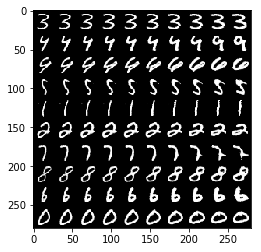

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image()[0], cmap='gray')

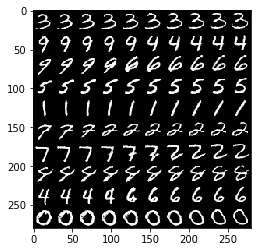

In [ ]:
imshow(get_sample_image()[1], cmap='gray')

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_info.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_info.pth.tar')